# Karar Ağaçları (Decision Trees)

Karar ağaçları, sınıflandırma ve regresyon problemlerinde yaygın olarak kullanılan, görsel olarak anlaşılır bir makine öğrenimi algoritmasıdır. Veri, çeşitli karar düğümleri üzerinden dallara ayrılır ve her dal bir özelliğe (feature) göre bölünür. En sonunda yaprak düğümlerde sınıflar yer alır.

- İstatistikte makine öğrenmesi başlığı altında birçok karar ağacı algoritması geliştirilmiştir.  
- Karar ağaçları akış şemalarına benzeyen yapılardır.  
- Her bir nitelik bir düğüm tarafından temsil edilir.  
- Dallar ve yapraklar ağaç yapısını oluşturan elemanlardır.  
- En son yapı **yaprak**, en üst yapı **kök** ve bunların arasında kalan yapılar ise **dal** olarak isimlendirilir (Quinlan).


## Entropi (Entropy)
Entropi, bir veri kümesindeki bilgi düzensizliğini ölçen bir metriktir. Ne kadar çok karışıklık (yani sınıf çeşitliliği) varsa, entropi o kadar yüksektir. Karar ağacı oluşturulurken amaç, dallanma işlemi ile entropiyi mümkün olduğunca azaltmaktır.

### Entropi Formülü

![formül](images/entropi_formul.png)

- 𝑆: veri kümesi,
- 𝑝𝑖: sınıf i'nin örnek içindeki oranı (olasılığı).


## Information Gain (Bilgi Kazancı)

Information Gain (IG), bir özellik (feature)'in hedef değişkenin (class) belirsizliğini ne kadar azalttığını ölçen bir metriktir. Özellikle karar ağaçlarında (Decision Trees) kullanılır ve veri kümesindeki en iyi bölmeyi (split) belirlemek için kullanılır.

- Bilgi kazancı ne kadar yüksekse, o özelliğin sınıflandırmaya katkısı o kadar fazladır.
- Bilgi kazancı sıfıra yakınsa, o özellik hedef değişken hakkında fazla bilgi taşımaz.
- Karar ağaçları Karar ağaçları maksimum yapan özelliği seçerek ağacı dallandırır

,Feature,Information Gain
0,Economy (GDP per Capita)_cat,0.371891
1,Family_cat,0.349109
2,Health (Life Expectancy)_cat,0.317482
3,Freedom_cat,0.212306
4,Dystopia Residual_cat,0.112074
5,Trust (Government Corruption)_cat,0.070376
6,Generosity_cat,0.048272


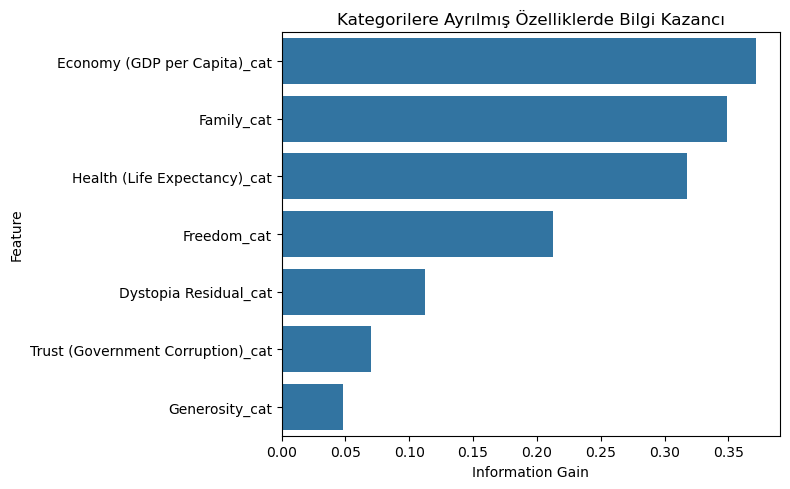

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("data.csv")  

# Medyan verilerin ortasındaki değerdir.
# Hedef değişkeni oluşturuyoruz: Medyanın üstü 'high', altı 'low'
# Sınıflandırma yapmak için veriyi 2 ye bölüyorum.
df['target'] = df['Happiness Score'].apply(lambda x: 'high' if x >= df['Happiness Score'].median() else 'low')

# Entropi hesaplama fonksiyonu
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))


# Bilgi kazancı hesaplama fonksiyonu
# Karar ağacının kök kısmını belirlemek için kullandım.
def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset = data[data[feature] == v]
        weighted_entropy += (c / len(data)) * entropy(subset[target])
    return total_entropy - weighted_entropy

# String ifadeleri iyi analiz etmek için bu yöntemi kullandım.
# Kategorik sütunları sayısal hale getir
encoded_df = df.copy()
le = LabelEncoder()
for col in encoded_df.columns:
    if encoded_df[col].dtype == 'object':
        encoded_df[col] = le.fit_transform(encoded_df[col])


# Sürekli değişkenleri 3 kategoriye ayırdık (low, mid, high)
features = [
    'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
    'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual'
]

binned_df = encoded_df.copy()
for col in features:
    binned_df[col + '_cat'] = pd.qcut(binned_df[col], q=3, labels=['low', 'mid', 'high'])


# Yeni kategorik sütunlara göre bilgi kazancı hesapla
target = 'target'
cat_features = [col + '_cat' for col in features]

info_gain_binned = {feature: information_gain(binned_df, feature, target) for feature in cat_features}
info_gain_binned_sorted = dict(sorted(info_gain_binned.items(), key=lambda item: item[1], reverse=True))

# Sonuçları tabloya aktar
ig_binned_df = pd.DataFrame.from_dict(info_gain_binned_sorted, orient='index', columns=['Information Gain'])
ig_binned_df.reset_index(inplace=True)
ig_binned_df.rename(columns={'index': 'Feature'}, inplace=True)
display(ig_binned_df)

# Bilgi kazancı grafiği çiz
plt.figure(figsize=(8, 5))
sns.barplot(x='Information Gain', y='Feature', data=ig_binned_df)
plt.title("Kategorilere Ayrılmış Özelliklerde Bilgi Kazancı")
plt.xlabel("Information Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Sonuç:
# Ekonomi, aile ve sağlık faktörleri, insanların mutluluğunu sınıflandırmada en etkili değişkenlerdir.

Doğruluk Oranı: 0.88
Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.84      0.94      0.89        17

    accuracy                           0.88        32
   macro avg       0.88      0.87      0.87        32
weighted avg       0.88      0.88      0.87        32



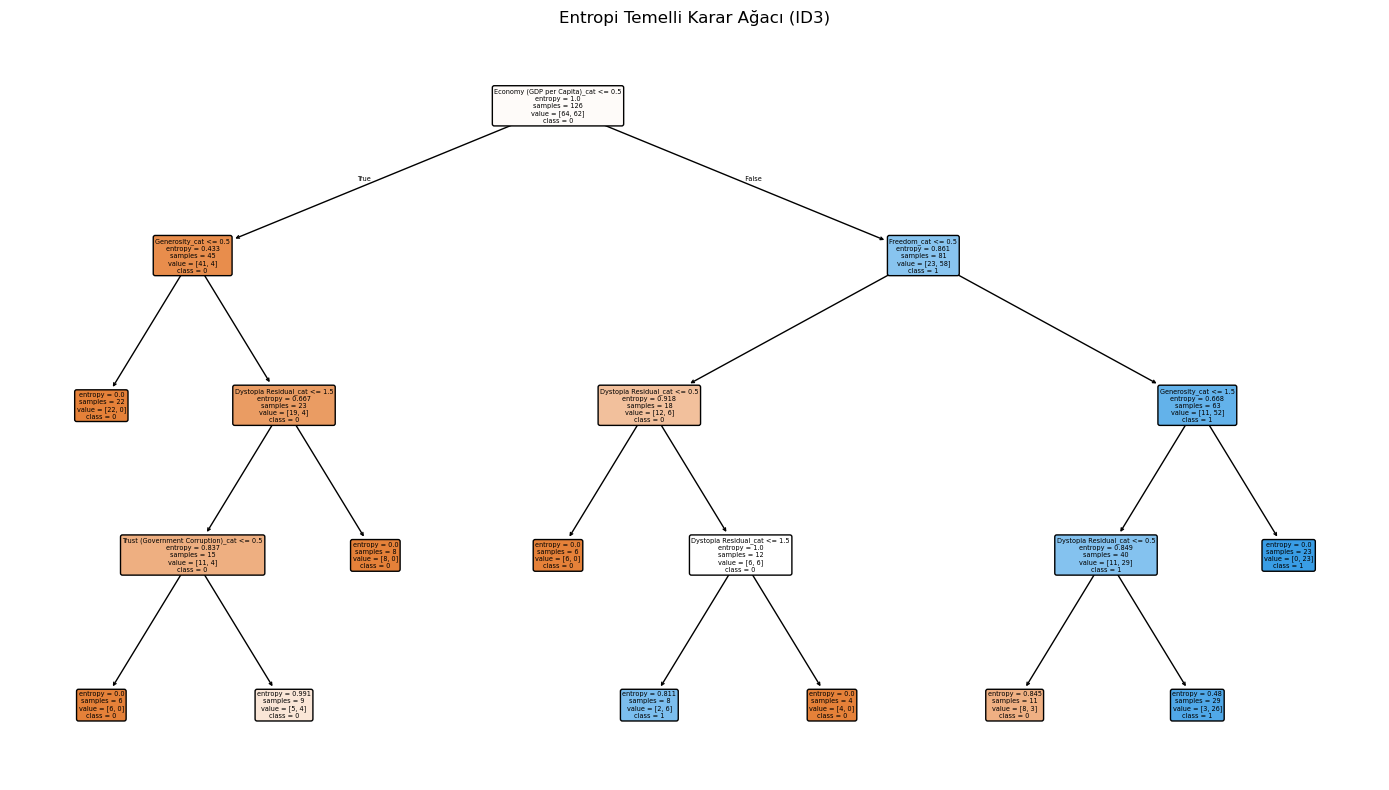

Karar Ağacı Kuralları:

|--- Economy (GDP per Capita)_cat <= 0.50
|   |--- Generosity_cat <= 0.50
|   |   |--- class: 0
|   |--- Generosity_cat >  0.50
|   |   |--- Dystopia Residual_cat <= 1.50
|   |   |   |--- Trust (Government Corruption)_cat <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Trust (Government Corruption)_cat >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Dystopia Residual_cat >  1.50
|   |   |   |--- class: 0
|--- Economy (GDP per Capita)_cat >  0.50
|   |--- Freedom_cat <= 0.50
|   |   |--- Dystopia Residual_cat <= 0.50
|   |   |   |--- class: 0
|   |   |--- Dystopia Residual_cat >  0.50
|   |   |   |--- Dystopia Residual_cat <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- Dystopia Residual_cat >  1.50
|   |   |   |   |--- class: 0
|   |--- Freedom_cat >  0.50
|   |   |--- Generosity_cat <= 1.50
|   |   |   |--- Dystopia Residual_cat <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Dystopia Residual_cat >  0.50
|   |   |   |   |--- class: 1
| 

In [6]:
# Karar ağacı oluşturma

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("data.csv")  # CSV yolunu kendi ortamına göre güncelle

# 2. Hedef değişkeni oluştur (median'a göre sınıflandırma)
df['target'] = df['Happiness Score'].apply(lambda x: 'high' if x >= df['Happiness Score'].median() else 'low')

# 3. Sayısal olmayan sütunları sayısallaştır
encoded_df = df.copy()
le = LabelEncoder()
for col in encoded_df.columns:
    if encoded_df[col].dtype == 'object':
        encoded_df[col] = le.fit_transform(encoded_df[col])

# 4. Sürekli değişkenleri kategorilere ayırıyoruz (qcut ile low/mid/high)
features = [
    'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
    'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual'
]

#Sayısal verileri gruplandırarak daha açıklayıcı hale getiriyoruz.
#Sonra bu verileri modelin anlayacağı sayısal forma sokuyoruz.
binned_df = encoded_df.copy()
for col in features:
    binned_df[col + '_cat'] = pd.qcut(binned_df[col], q=3, labels=['low', 'mid', 'high'])

cat_features = [col + '_cat' for col in features]
target = 'target'

# 5. Özellikleri encode et (low/mid/high -> 0/1/2)
X = binned_df[cat_features].apply(LabelEncoder().fit_transform)
y = binned_df[target]

# 6. Eğitim/test ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Entropi kriterli karar ağacı modeli (ID3 benzeri)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# 8. Tahmin ve doğruluk oranı
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk Oranı: {accuracy:.2f}")

print("Sınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred))

# 9. Karar ağacı görselleştirme
plt.figure(figsize=(14, 8))
plot_tree(clf, feature_names=cat_features, class_names=[str(c) for c in clf.classes_], filled=True, rounded=True)
plt.title("Entropi Temelli Karar Ağacı (ID3)")
plt.tight_layout()
plt.show()


# 10. Karar kuralları metni
rules = export_text(clf, feature_names=cat_features)
print("Karar Ağacı Kuralları:\n")
print(rules)


### Model Performans Sonuçları

**Doğruluk Oranı (Accuracy):** `0.88`

Aşağıdaki tablo, modelin sınıflandırma performans metriklerini özetlemektedir:

| Sınıf | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **low (0)** | 0.92 | 0.80 | 0.86 | 15 |
| **high (1)** | 0.84 | 0.94 | 0.89 | 17 |

**Genel Ölçütler:**

| Metrik | Precision | Recall | F1-Score | Support |
|--------|-----------|--------|----------|---------|
| **Accuracy**        | -     | -     | **0.88** | 32 |
| **Macro Average**   | 0.88  | 0.87  | 0.87     | 32 |
| **Weighted Average**| 0.88  | 0.88  | 0.87     | 32 |

**Yorum:**
- Model, `"low"` sınıfında yüksek doğrulukla tahmin yapabilmekte (`precision: 0.92`) ancak bazılarını atlayabiliyor (`recall: 0.80`).
- `"high"` sınıfında ise daha fazla örneği doğru tahmin ediyor (`recall: 0.94`) ama precision biraz daha düşük (`0.84`).
- Genel olarak dengeli ve başarılı bir model performansı görülüyor.


### Precision ve Recall Nedir?

**Precision (Kesinlik):**  
Modelin **pozitif tahminlerinden kaç tanesi gerçekten pozitifti?**  
> Yani: `Gerçek Doğru / (Gerçek Doğru + Yanlış Pozitif)`  
Örneğin: Model "high" dediğinde gerçekten ne kadar doğru söyledi?

**Recall (Duyarlılık / Geri Çağırma):**  
Modelin **gerçek pozitifleri ne kadar iyi yakalayabildiğini** gösterir.  
> Yani: `Gerçek Doğru / (Gerçek Doğru + Atlanan Pozitif)`  
Örneğin: Gerçekten "high" olanların ne kadarını yakalayabildi?

---

###  Neden Farklı Sonuçlar Gösterir?

Precision ve Recall genellikle **birbiriyle ters orantılıdır**:

- **Precision yüksek ama Recall düşükse**: Model az ama çok emin tahminler yapıyordur. (daha az "high" diyor ama dediği kesin doğru)
- **Recall yüksek ama Precision düşükse**: Model daha fazla tahmin yapıyor ama bunların bazıları yanlış. (çoğu "high"ı yakalıyor ama arada "low"ları da yanlışlıkla "high" diyor)

---

###  Bu Modelde Ne Oldu?

| Sınıf | Precision | Recall |
|-------|-----------|--------|
| `low (0)` | **0.92** | 0.80 |
| `high (1)` | 0.84 | **0.94** |

- Model, `"low"` dediğinde %92 oranında doğru (yüksek precision), ancak `"low"` olanların %80’ini yakalamış (recall daha düşük).
- `"high"` sınıfında ise neredeyse tüm gerçek “high”ları yakalamış (recall 0.94), ama bu sırada bazı “low”ları yanlışlıkla “high” demiş olabilir (precision 0.84).

---

###  Sonuç:

Bu model genel olarak dengeli ve iyi performans gösteriyor.  
Ancak senaryo gereği:
- **Yanlış pozitifler (false positive)** önemliyse → **Precision** kritik olur.
- **Atlanan pozitifler (false negative)** önemliyse → **Recall** öncelikli olur.


